In [1]:
from math import log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None
pd.options.mode.use_inf_as_null = True

In [2]:
def load_data(dummies=False, numbers_only=False, threshold=25, logs=False):
    test = pd.read_csv('test.csv')
    test.set_index('Id', inplace=True)
    train = pd.read_csv('train.csv')
    train.set_index('Id', inplace=True)
    full = pd.concat([train, test])

    if (dummies) or (numbers_only) or (logs):
        full = pd.concat([train, test])
        coldict = {
            'regr': ['SalePrice'],
            'class': ['SalePrice']
        }
        for col in full.columns:
            if col == 'SalePrice':
                continue
            if train[col].dtypes == 'object':
                coldict['class'].append(col)
            else:
                if len(train[col].unique()) < threshold:
                    coldict['class'].append(col)
                else:
                    coldict['regr'].append(col)

    if dummies:
        full = pd.get_dummies(full, drop_first=True)
    
    if logs:
        orig_cols = coldict['regr'][:]
        for col in orig_cols:
            full['ln_'+col] = np.log(full[col])
            coldict['regr'].append('ln_'+col)
                
    if numbers_only:
        train = train[coldict['regr']]
        coldict['regr'].remove('SalePrice')
        test = test[coldict['regr']]
        return train, test
    
    train = full[0:1460]
    test = full[1460:2919]
    return train, test

In [3]:
def display_data():
    train, test = load_data()
    display(train.head())
    display(test.head())
display_data()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1461,896,0,0,NaN,2,1Fam,TA,No,468.0,144.0,...,WD,120,Pave,5,882.0,AllPub,140,1961,1961,2010
1462,1329,0,0,NaN,3,1Fam,TA,No,923.0,0.0,...,WD,0,Pave,6,1329.0,AllPub,393,1958,1958,2010
1463,928,701,0,NaN,3,1Fam,TA,No,791.0,0.0,...,WD,0,Pave,6,928.0,AllPub,212,1997,1998,2010
1464,926,678,0,NaN,3,1Fam,TA,No,602.0,0.0,...,WD,0,Pave,7,926.0,AllPub,360,1998,1998,2010
1465,1280,0,0,NaN,2,TwnhsE,TA,No,263.0,0.0,...,WD,144,Pave,5,1280.0,AllPub,0,1992,1992,2010


In [15]:
def poly_features(df):
    if 'SalePrice' in df.columns:
        y = df['SalePrice'].reset_index()
        df.drop('SalePrice', axis=1, inplace=True)
        
    elif 'ln_SalePrice' in df.columns:
        y = df['ln_SalePrice'].reset_index()
        df.drop('ln_SalePrice', axis=1, inplace=True)
        
    else:
        y = df.reset_index()['Id']
    
    df.fillna(0, inplace=True)
    poly = pp.PolynomialFeatures(2)
    df = pd.DataFrame(poly.fit_transform(df), columns=poly.get_feature_names(df.columns))
    
    if len(y.shape) == 2:
        df = pd.concat([df, y], axis=1)
    else:
        df['Id'] = y

    return df

In [6]:
def ml_conv(df):
    if 'SalePrice' in  df.columns:
        Y = df['SalePrice']
        X = df.drop('SalePrice', axis=1)
        Y = Y.as_matrix()
    elif 'ln_SalePrice' in  df.columns:
        Y = df['ln_SalePrice']
        X = df.drop('ln_SalePrice', axis=1)
        Y = Y.as_matrix()
    else:
        X = df[:]
        Y = None
    varnames = X.columns    
    X = X.replace([np.inf, -np.inf], np.nan)
    X.fillna(0, inplace=True)
    
    X = X.as_matrix()
    
    return X, Y, varnames

def results_display(test, summary=True, data=True, graph=True):
    test = test.rename(columns={"ln_SalePrice": "SalePrice"})
    test['err'] = test['pred'] - test['SalePrice']
    test['err2'] = test['err'] ** 2
    
    test['l_err'] = (np.log(test['pred'])+1) - (np.log(test['SalePrice'])+1)
    test['l_err2'] = test['l_err'] ** 2
    
    if summary:
        print("RMSE: ${:,.2f}".format(np.sqrt(test['err2'].mean())))
        print("LRMSE: ", test['l_err2'].mean())
        print("Mean Error: ${:.2f} ± ${:,.2f}".format(test['err'].mean(), test['err'].std()))

    if data:
        pd.options.display.float_format = '${:,.2f}'.format
        display(test[['SalePrice', 'pred', 'err']].head(10))

    if graph:
        sns.regplot(x=test['SalePrice'], y=test['pred'])
        plt.show()

        temp = test[abs(test['err']) < test['err'].std()*3]
        sns.distplot(temp['err'])
        plt.show()

In [7]:
def regr_train(train, summary=True, data=True, graph=True):
    if 'ln_SalePrice' in train.columns:
        ln_flag = True
    else:
        ln_flag = False
    
    train, test = train_test_split(train, test_size=0.2)
    train_X, train_Y, varnames = ml_conv(train)
    test_X, test_Y, varnames = ml_conv(test)

    regr = linear_model.LinearRegression()

    regr.fit(train_X, train_Y)
    pred = regr.predict(test_X)
    test['pred'] = pred
    if ln_flag:
        test['pred'] = np.exp(test['pred'])
        test['ln_SalePrice'] = np.exp(test['ln_SalePrice'])
    results_display(test, summary, data, graph)
    
    return regr

In [8]:
train, validation = load_data(numbers_only=True)
regr_train(train, graph=False, data=False)

RMSE: $38,419.66
LRMSE:  0.0320297378568
Mean Error: $-4118.21 ± $38,263.88


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
train, validation = load_data(dummies=True)
regr_train(train, graph=False, data=False)

RMSE: $32,447.27
LRMSE:  0.0202359996934
Mean Error: $2634.38 ± $32,395.67


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
train, validation = load_data(dummies=True, logs=True)

print('SalePrice')
regr_train(train.drop('SalePrice', axis=1), graph=False, data=False)

print('\nln_SalePrice')
regr_train(train.drop('ln_SalePrice', axis=1), graph=False, data=False)

SalePrice
RMSE: $24,393.11
LRMSE:  0.0156829105599
Mean Error: $-1311.17 ± $24,399.67

ln_SalePrice
RMSE: $27,758.11
LRMSE:  0.0210708074529
Mean Error: $1843.85 ± $27,744.35


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

RMSE: $133,108.53
LRMSE:  0.337366753877
Mean Error: $-2933.71 ± $133,304.66


,SalePrice,pred,err
Id,,,
37,"$145,000.00","$160,497.37","$15,497.37"
1191,"$168,000.00","$221,546.54","$53,546.54"
872,"$200,500.00","$199,932.37",$-567.63
767,"$196,500.00","$152,876.05","$-43,623.95"
1386,"$125,500.00","$114,008.49","$-11,491.51"
1405,"$105,000.00","$-34,845.98","$-139,845.98"
935,"$242,000.00","$1,044,882.81","$802,882.81"
512,"$202,665.00","$233,161.14","$30,496.14"
942,"$214,000.00","$669,936.82","$455,936.82"


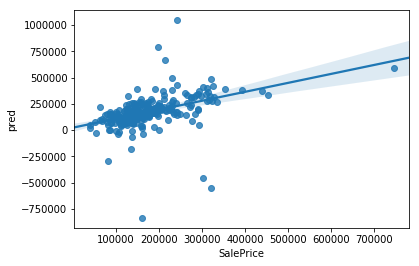

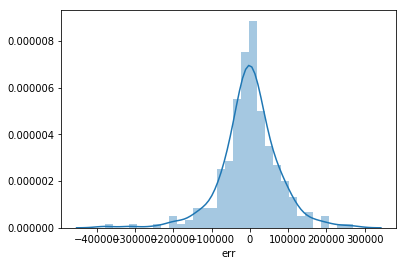

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
train, validation = load_data(dummies=True, logs=True)

full = pd.concat([train, validation])
full.drop('ln_SalePrice', inplace=True, axis=1)
full = poly_features(full)
full.set_index('Id', inplace=True)

train = full[1:1460]
validation = full[1460:2919]

regr_train(train)

## Submission 1
### Regressors + Dummy Variables Only
#### Score: 0.22043 | Rank 3469  / 3892

In [12]:
train, validation = load_data(dummies=True)

dreg = regr_train(train, graph=False, data=False)

c_val, a, varnames = ml_conv(validation)
pred = dreg.predict(c_val)

validation['SalePrice'] = pred

validation['SalePrice'].to_csv('submission_1.csv', header=True)

RMSE: $76,720.90
LRMSE:  0.035313281392
Mean Error: $-6096.23 ± $76,609.61


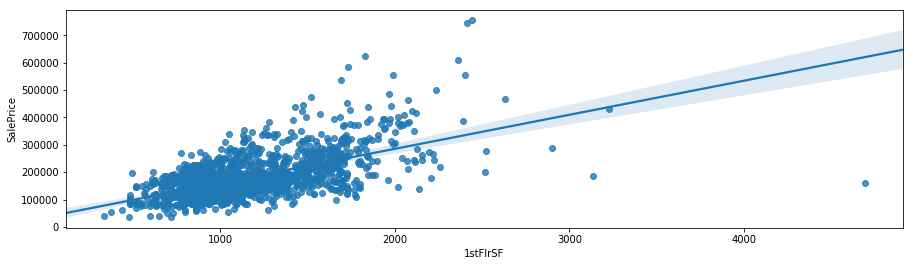

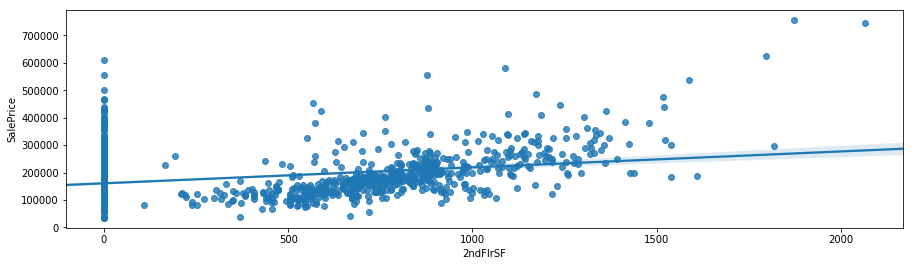

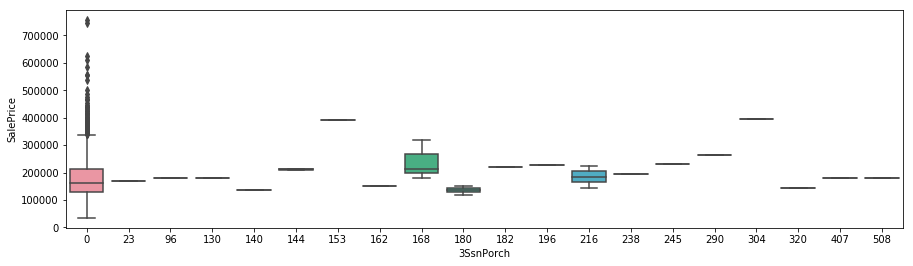

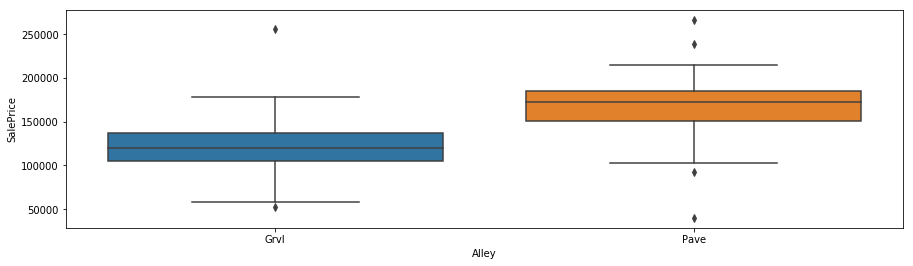

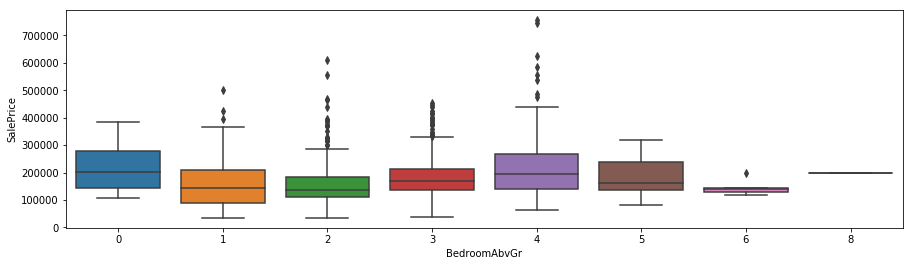

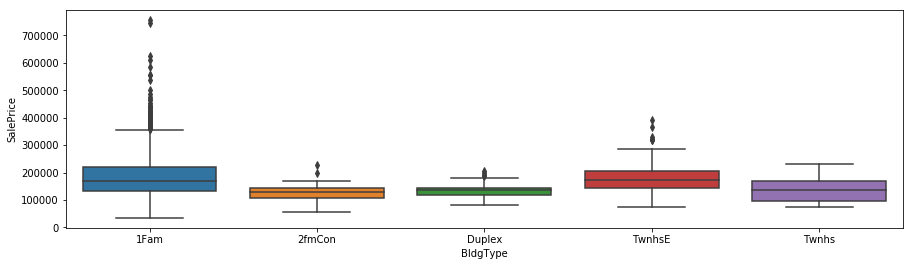

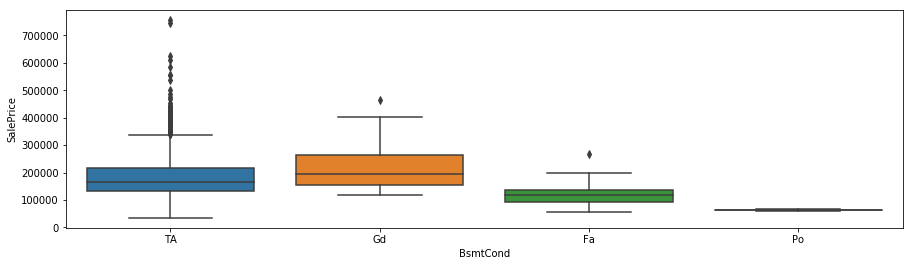

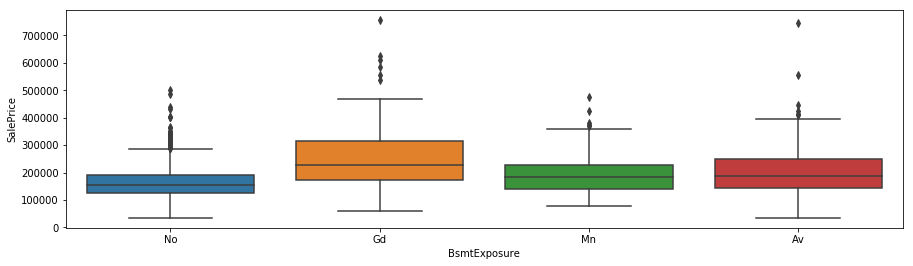

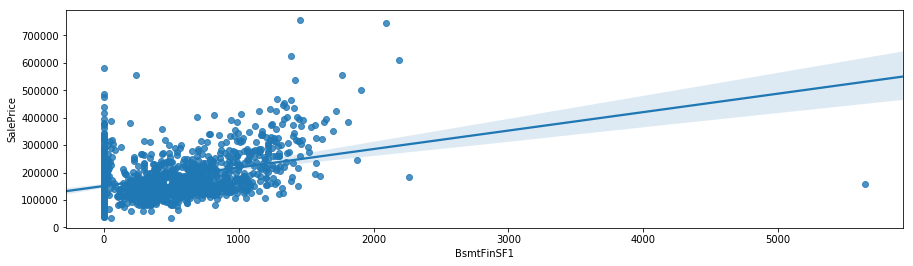

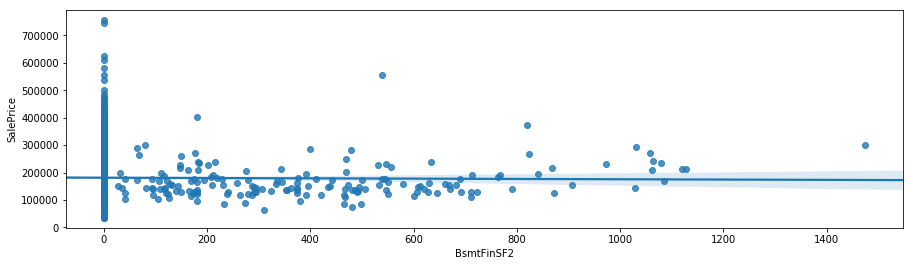

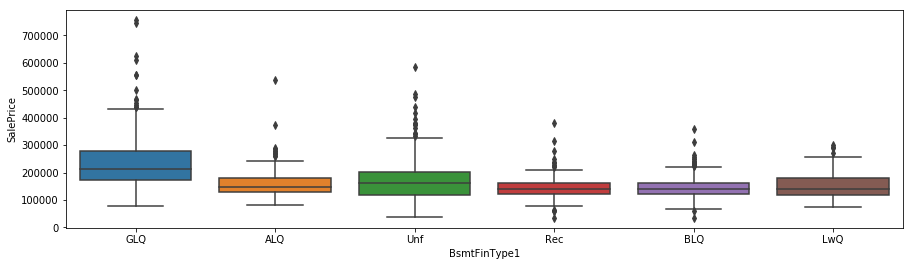

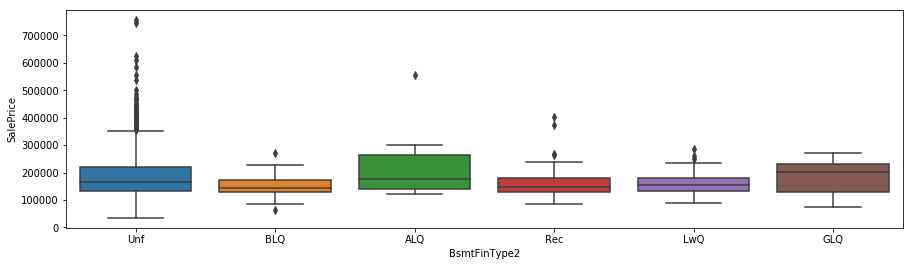

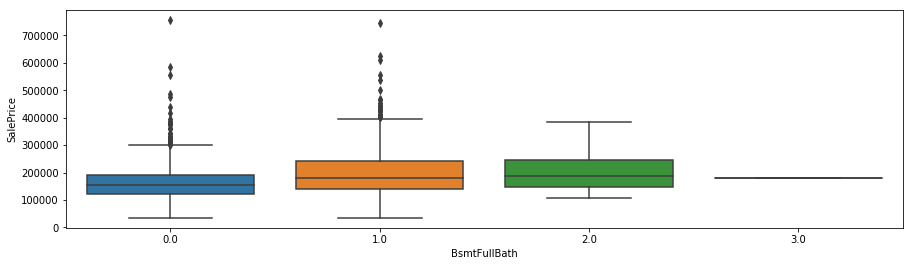

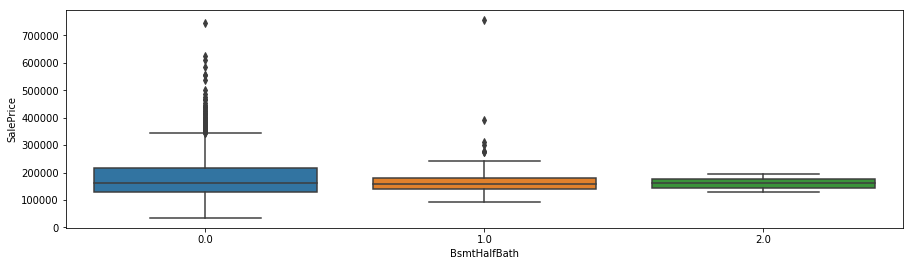

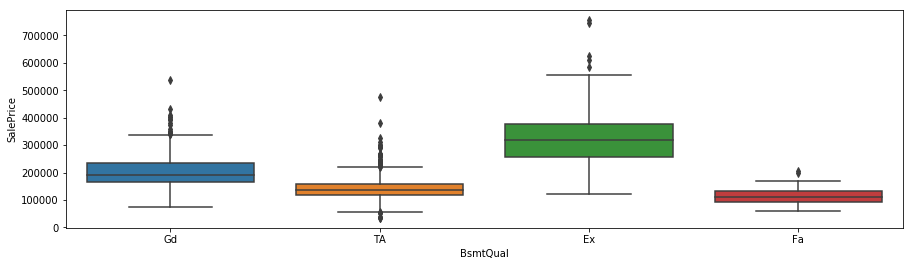

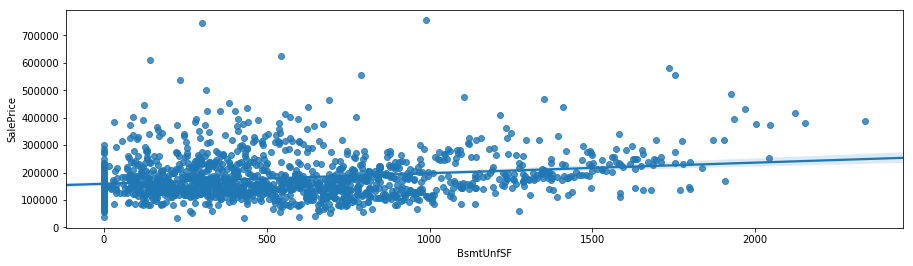

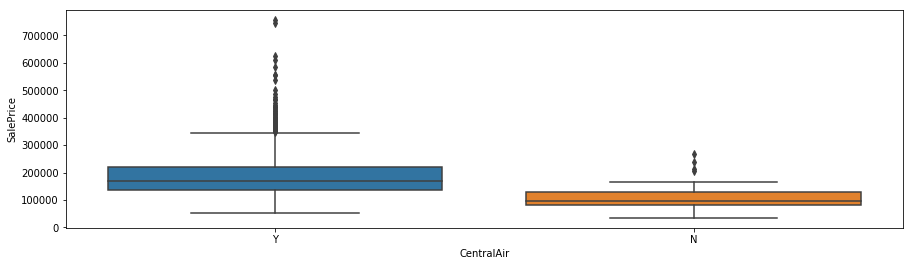

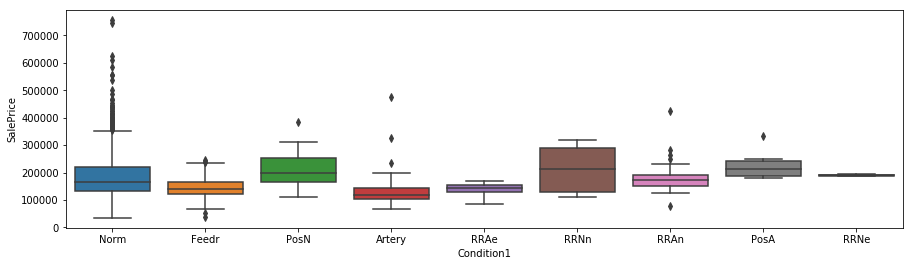

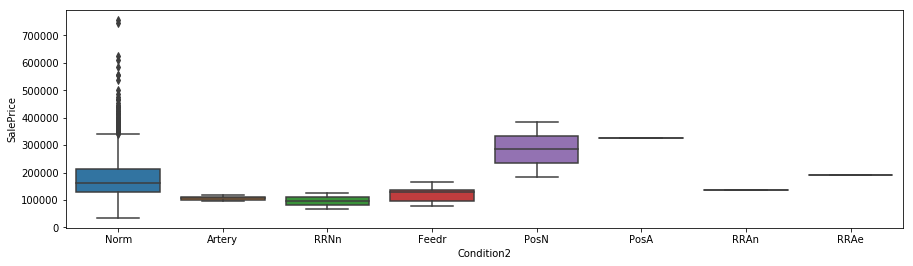

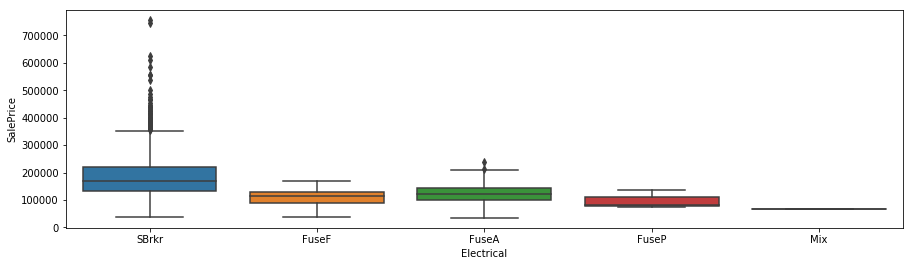

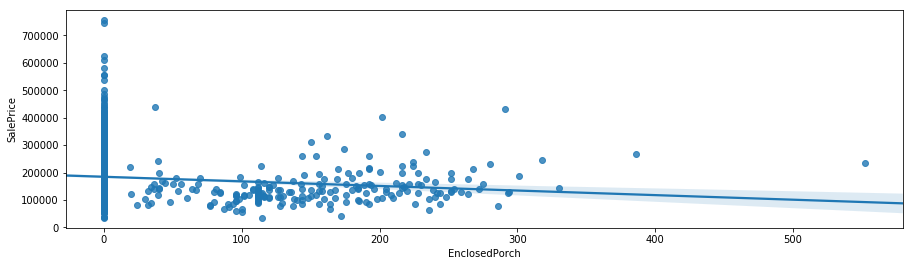

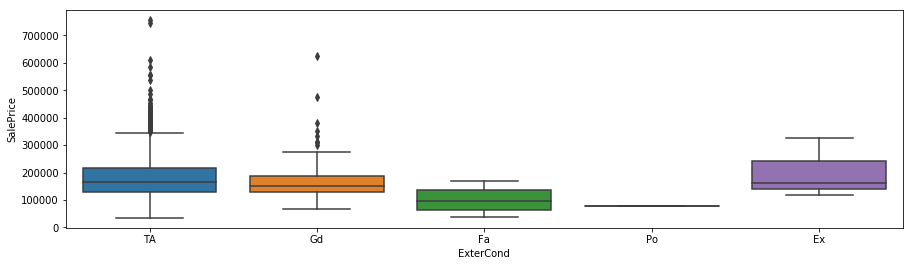

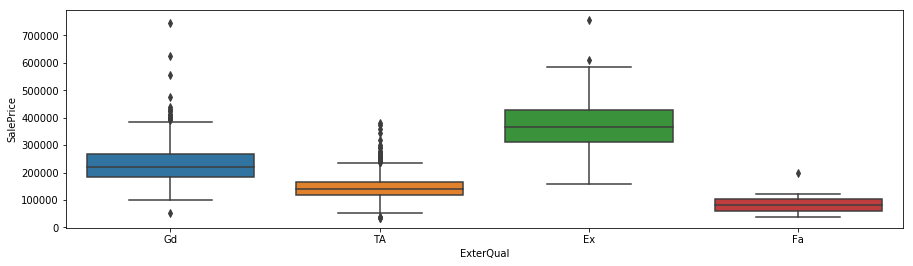

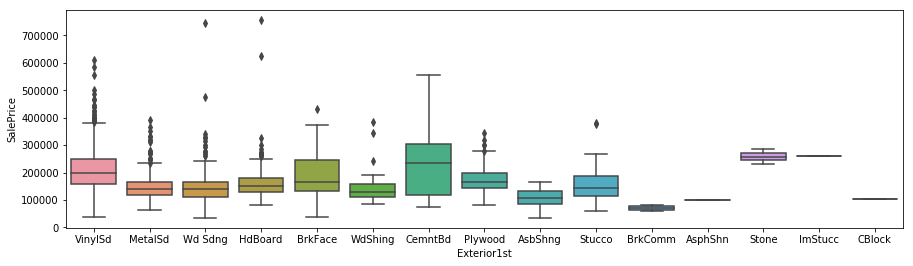

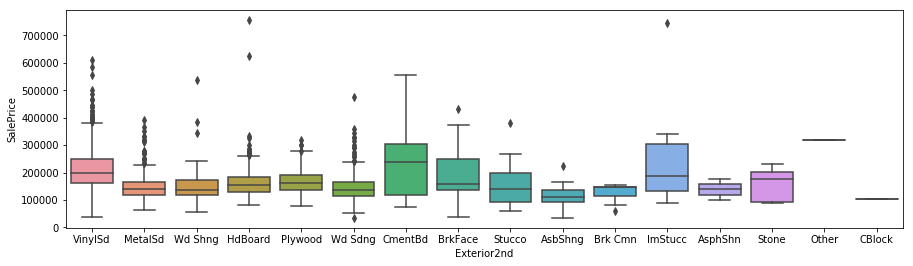

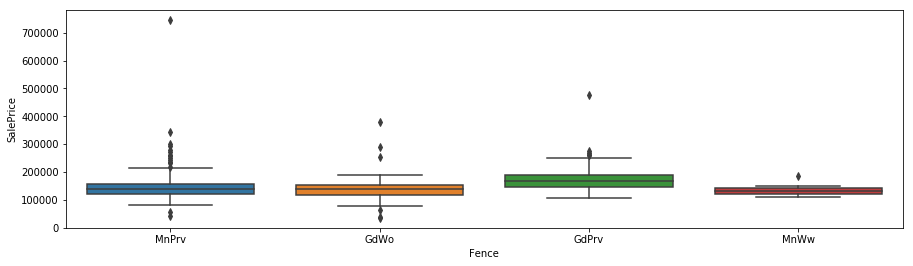

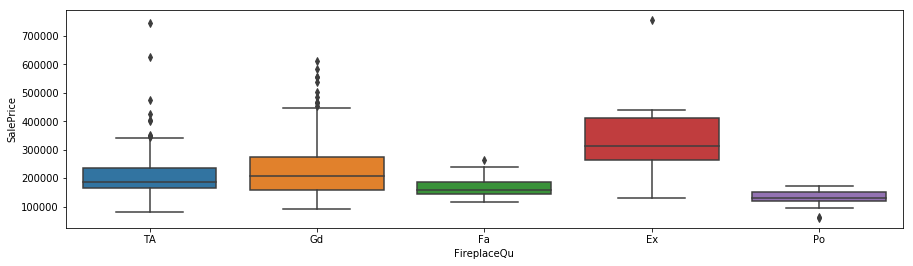

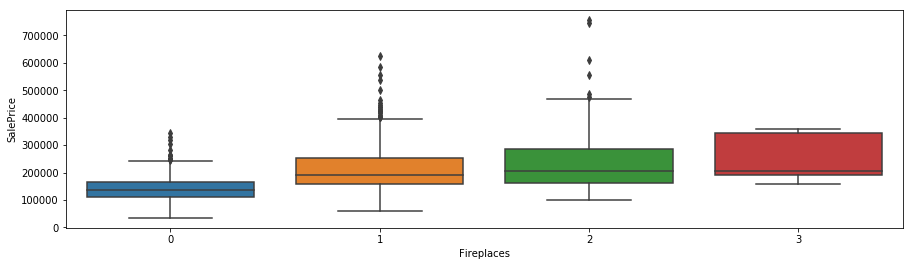

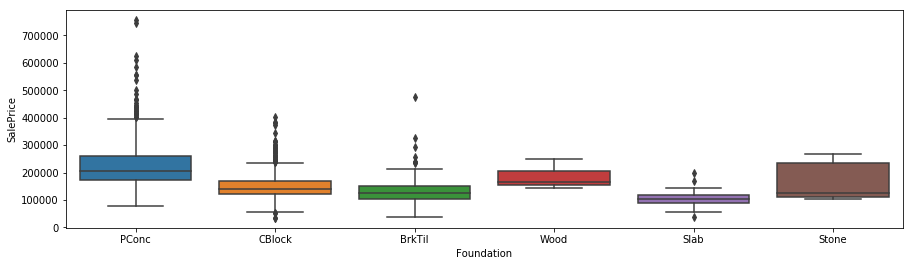

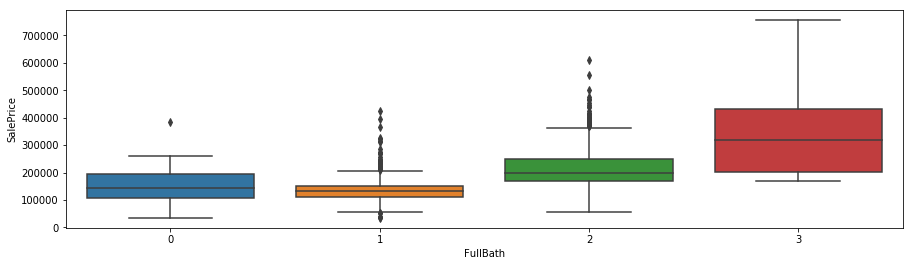

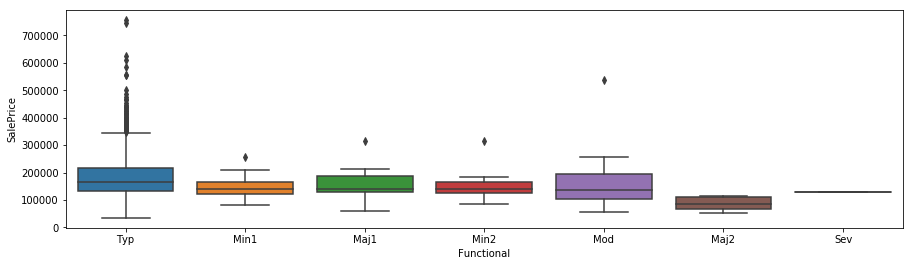

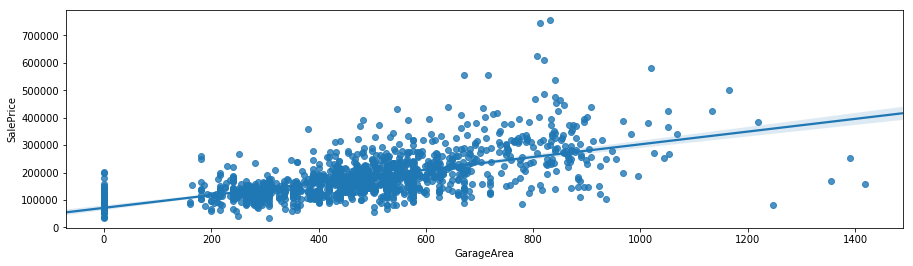

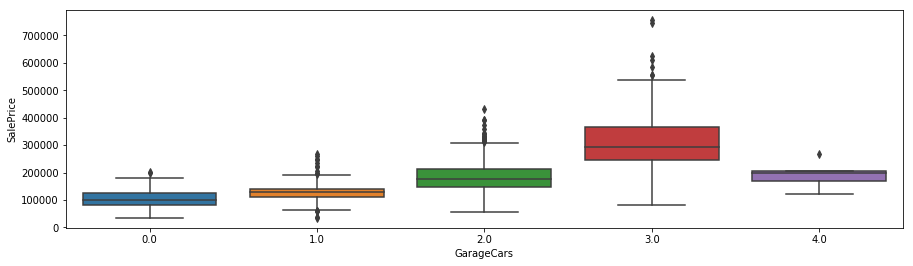

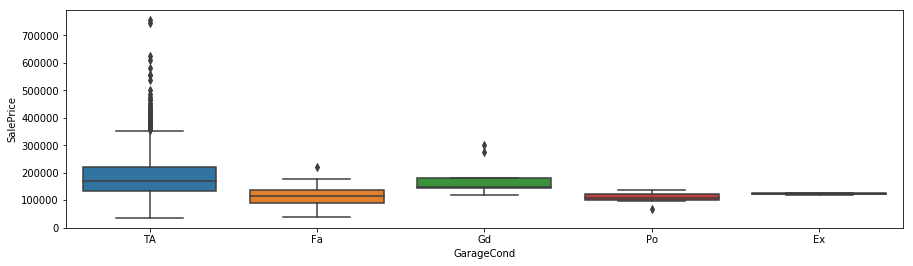

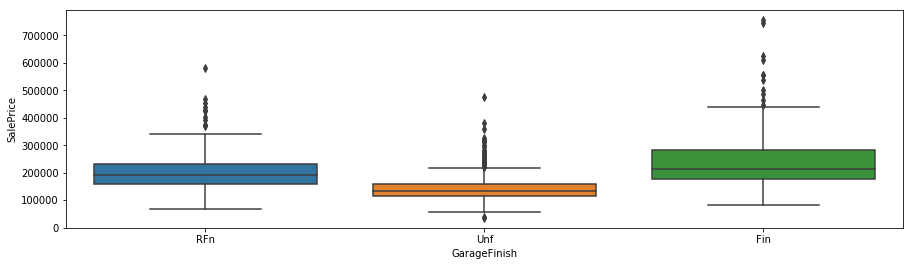

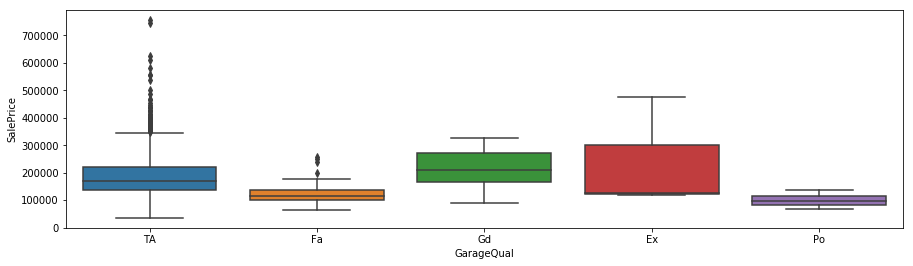

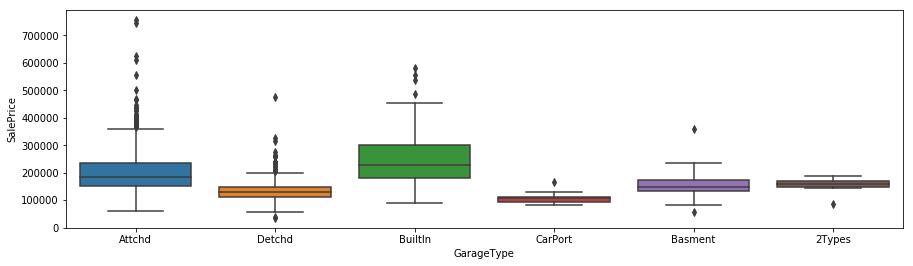

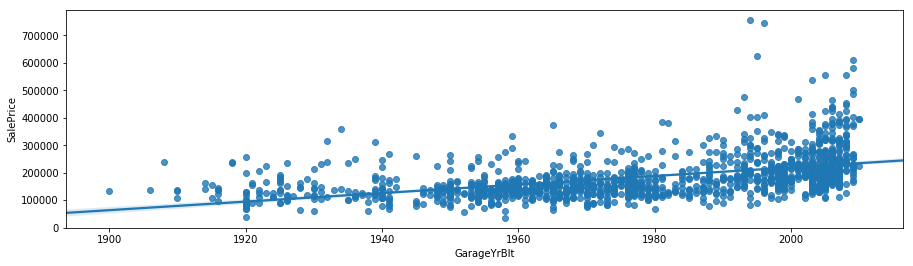

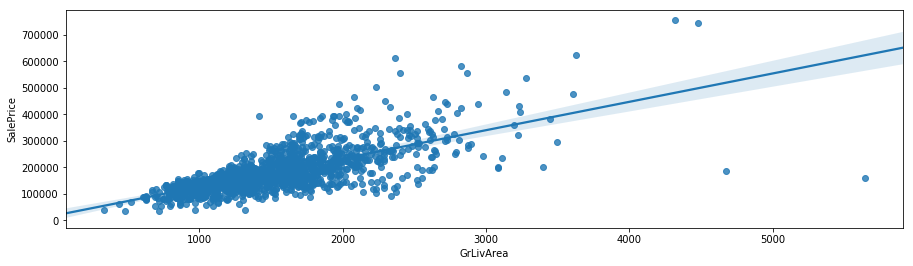

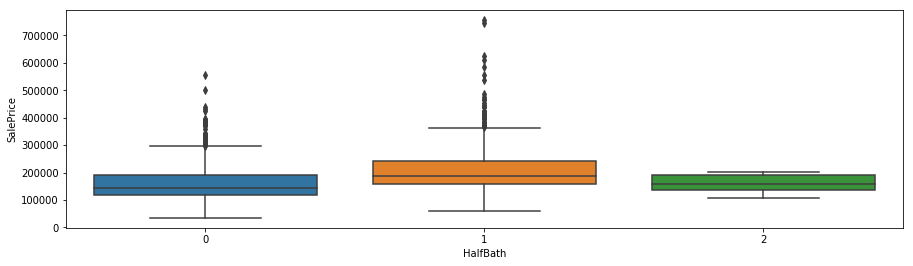

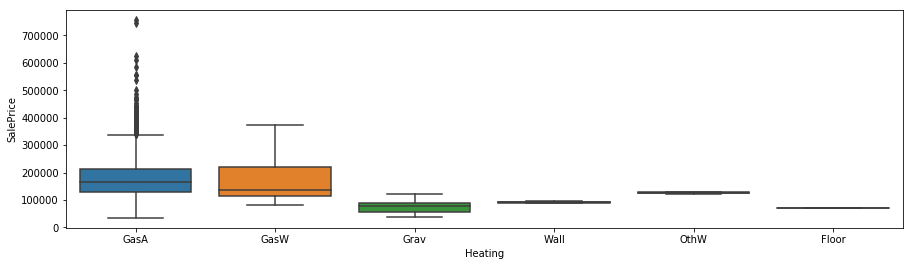

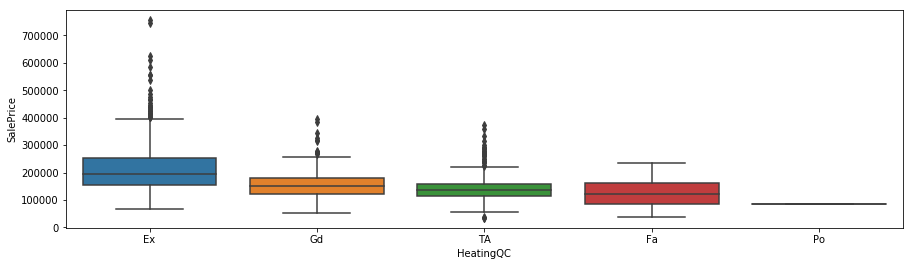

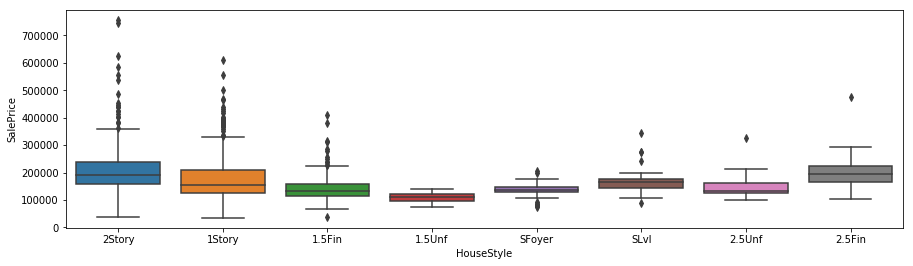

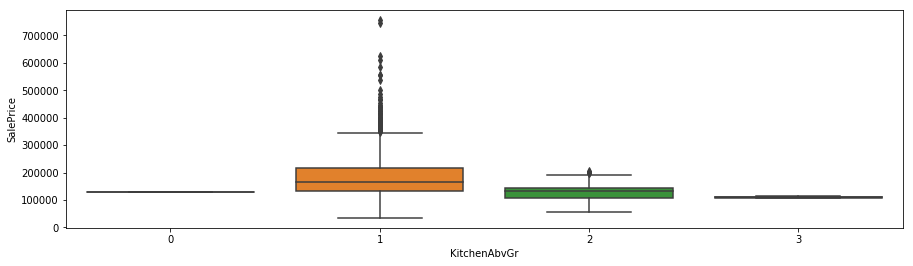

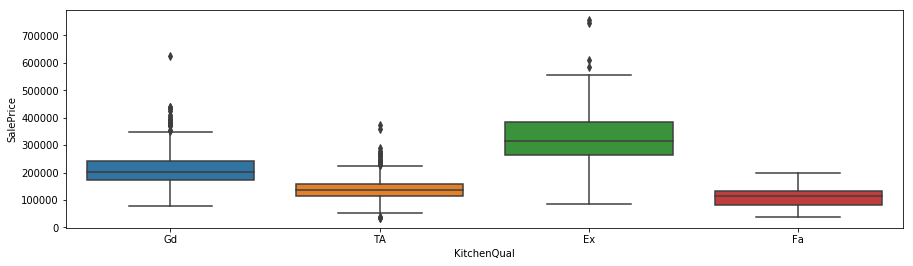

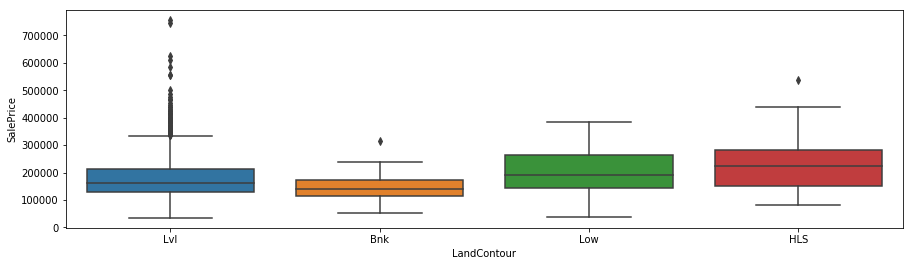

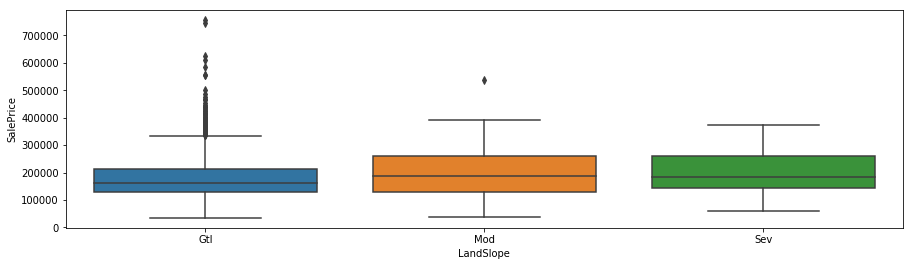

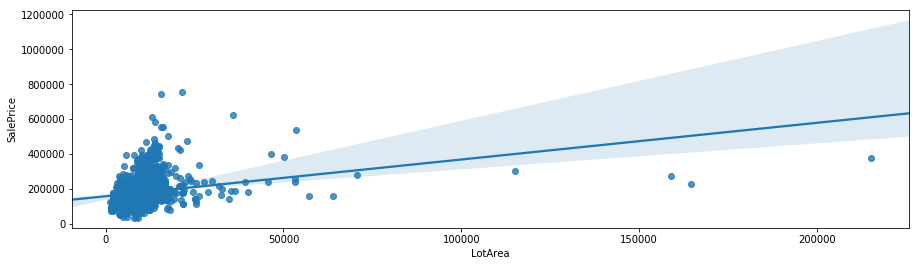

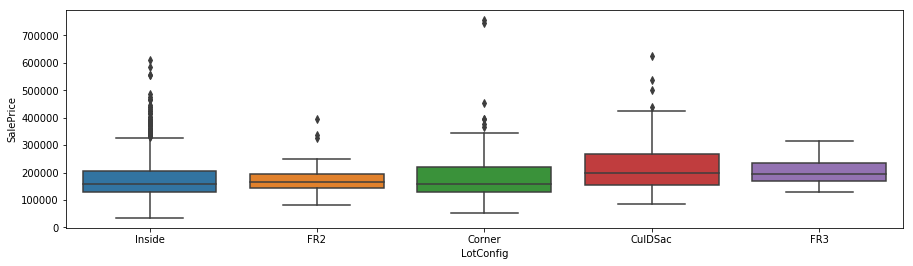

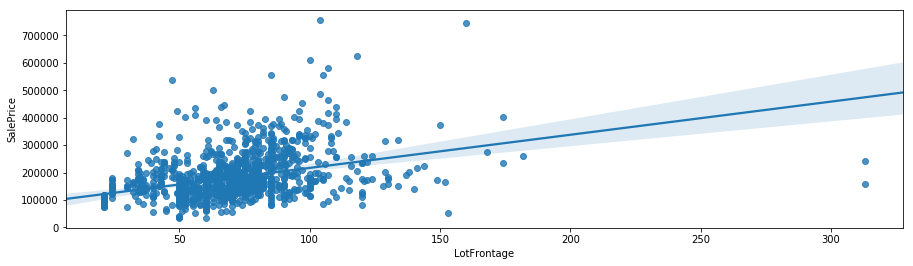

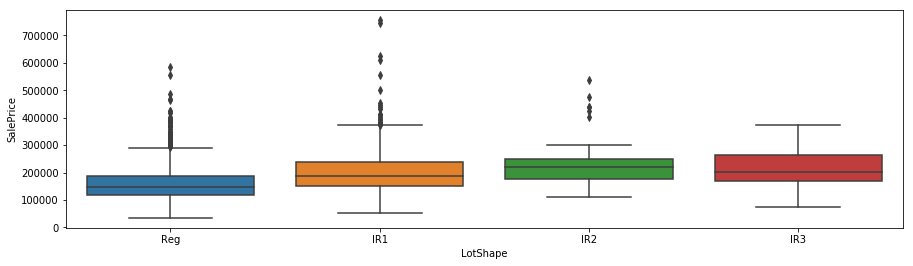

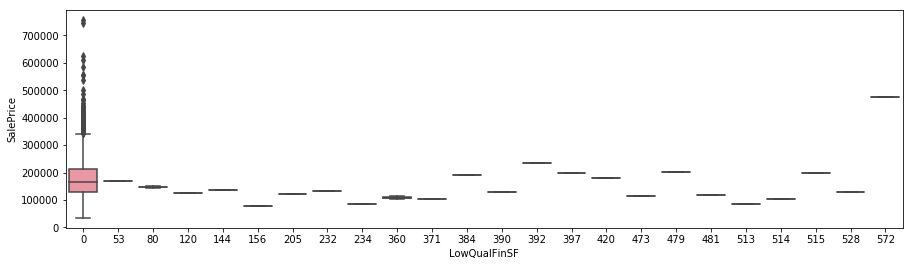

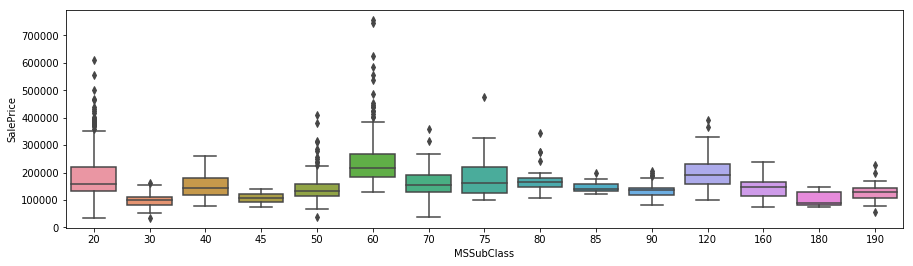

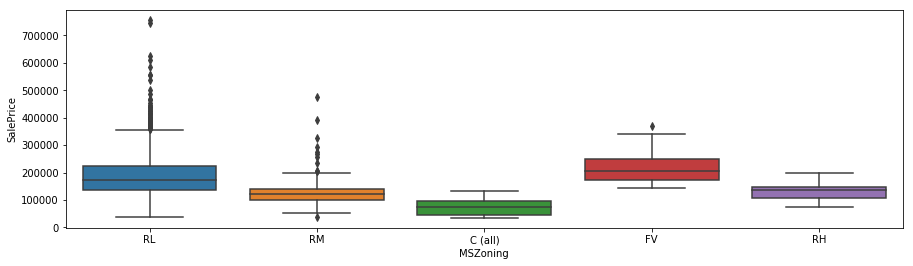

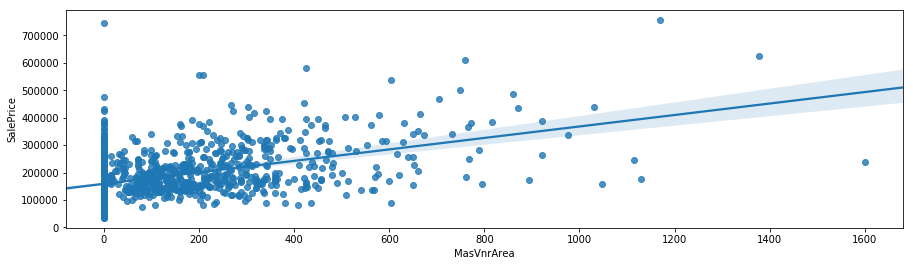

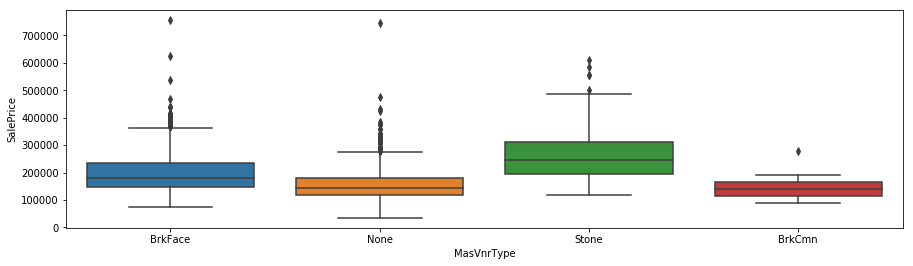

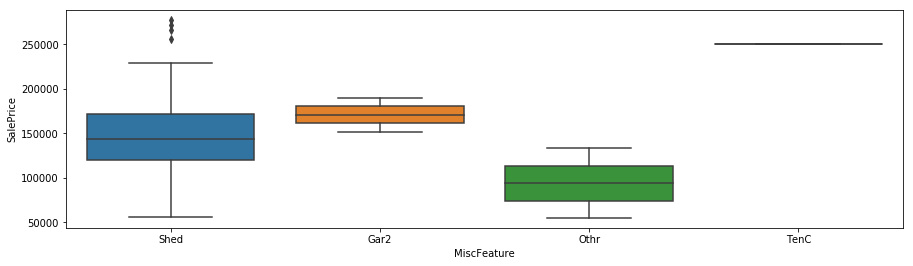

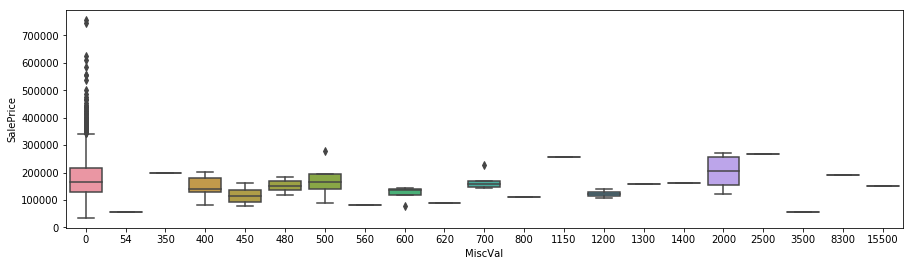

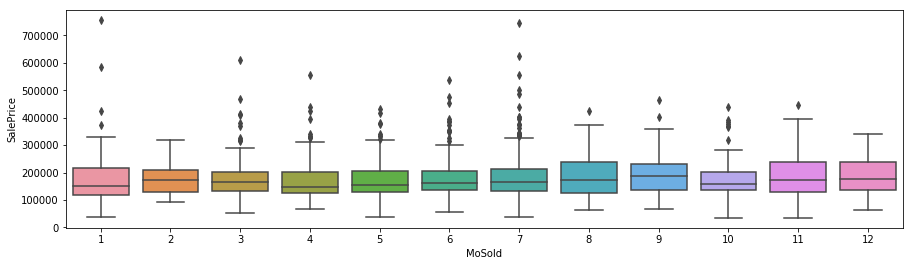

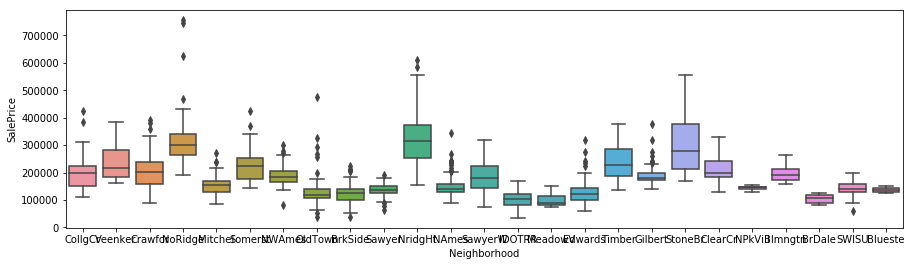

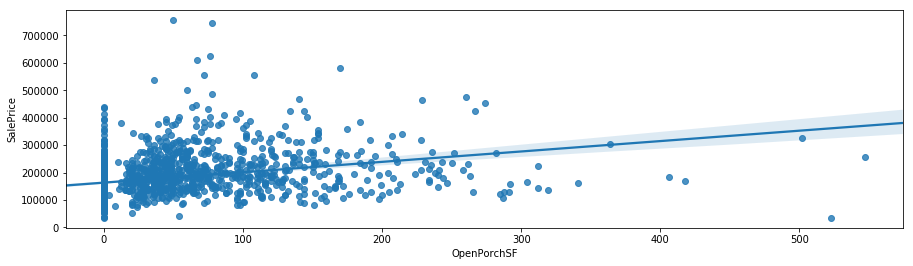

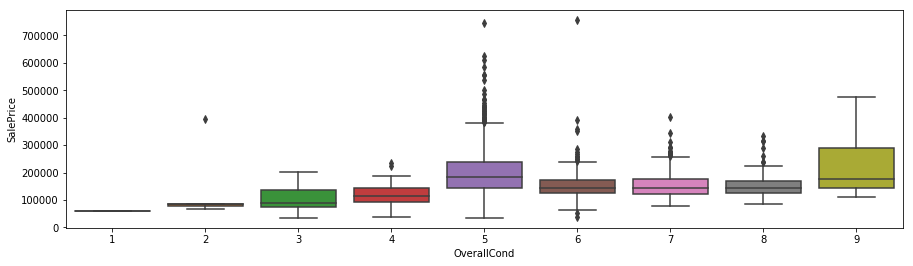

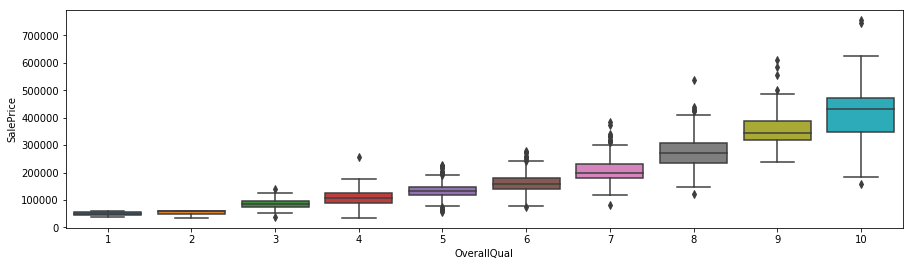

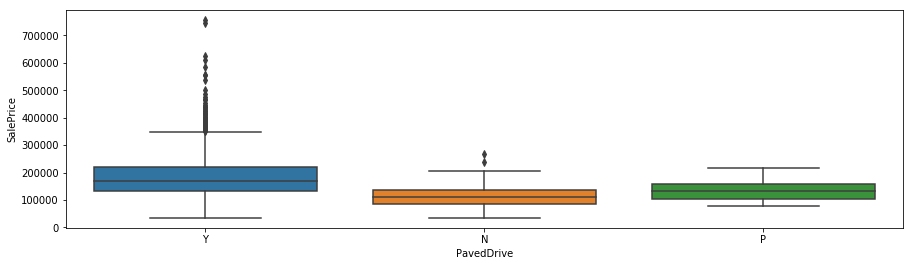

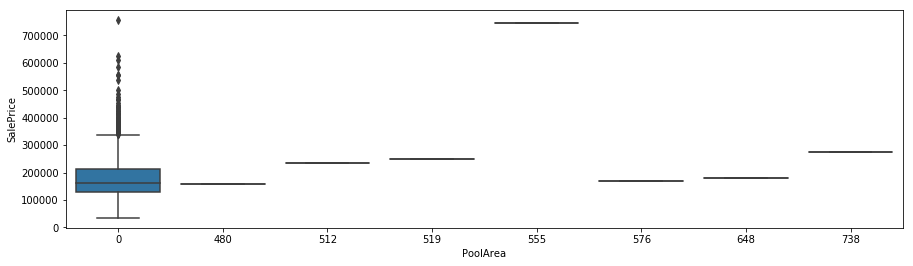

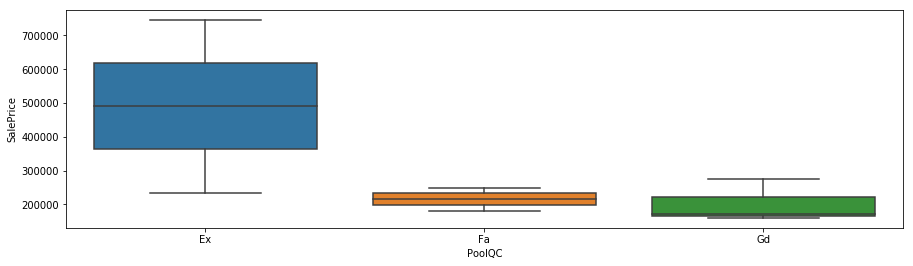

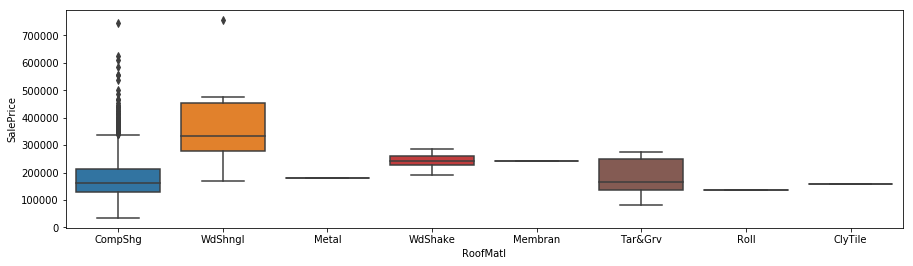

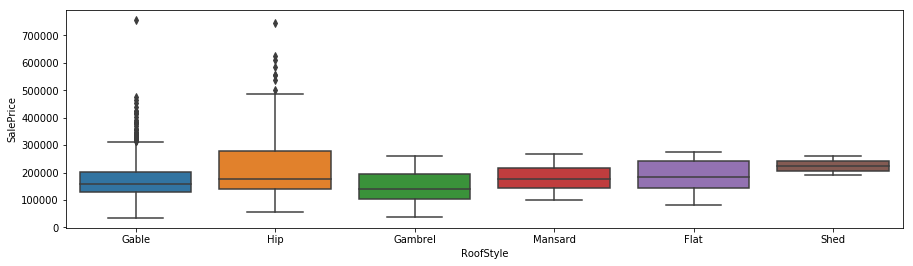

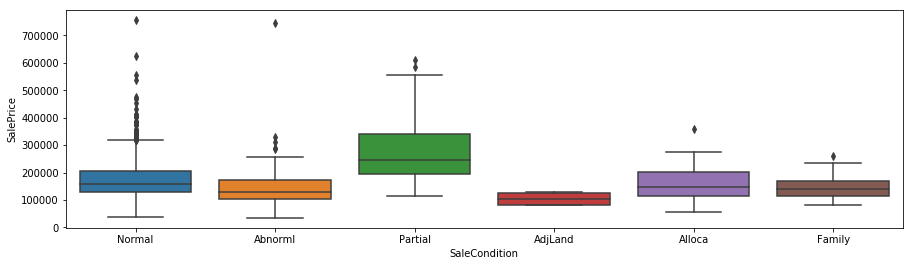

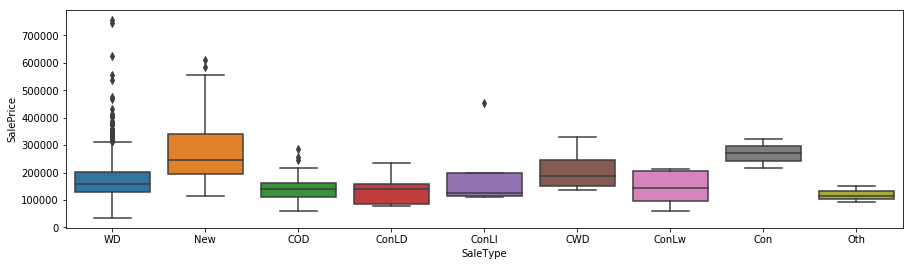

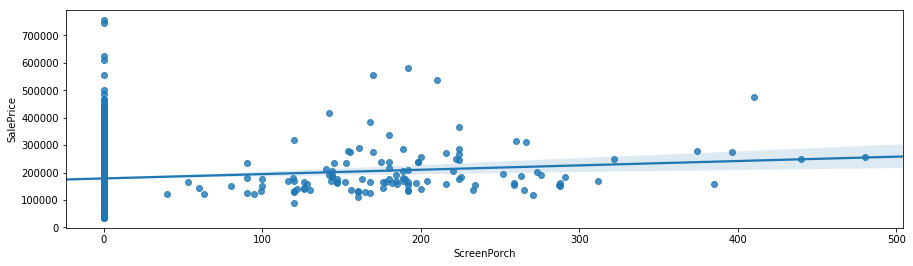

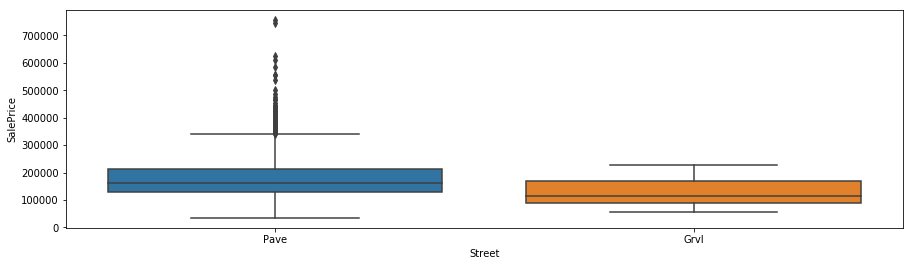

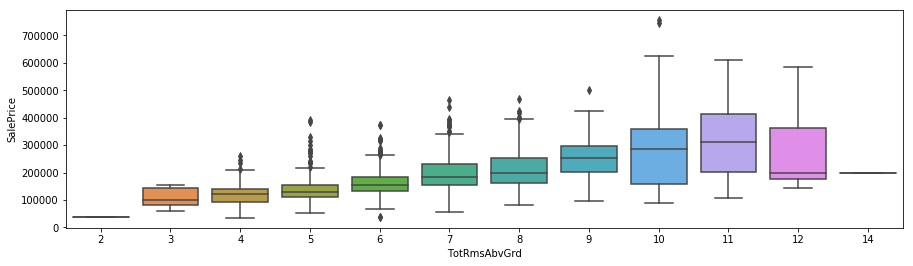

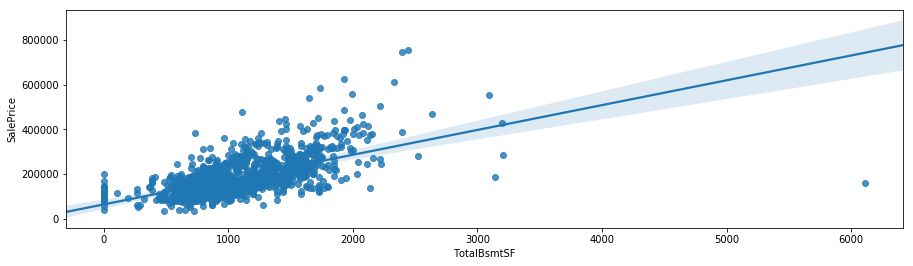

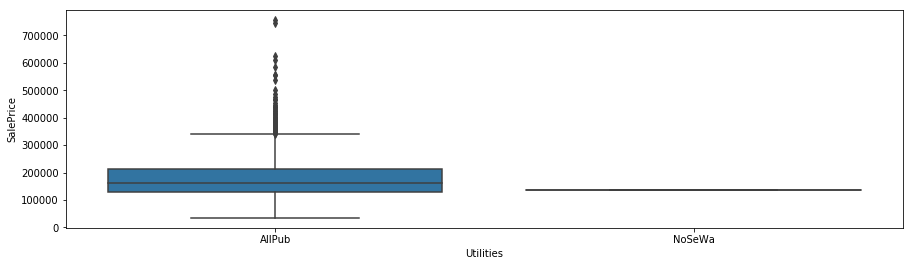

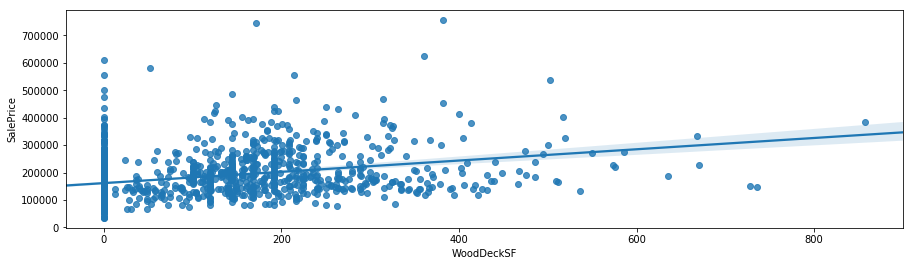

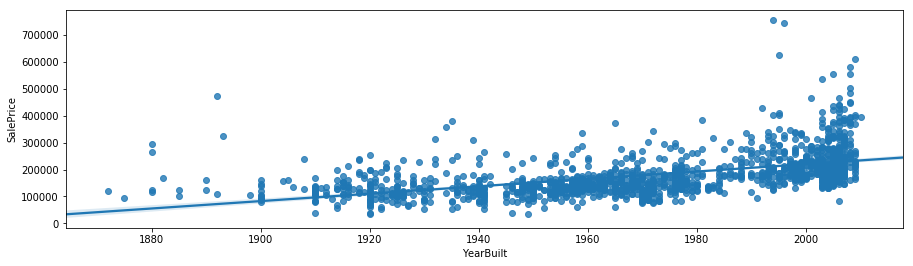

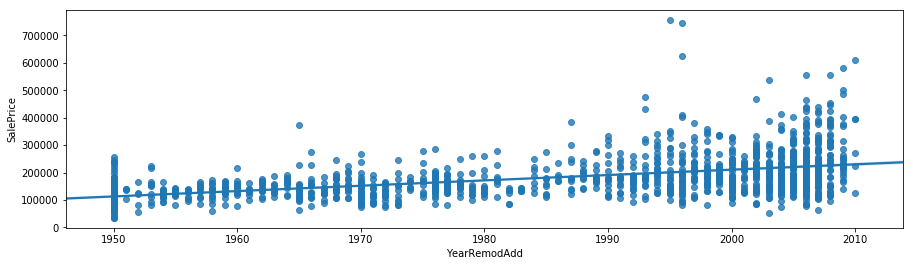

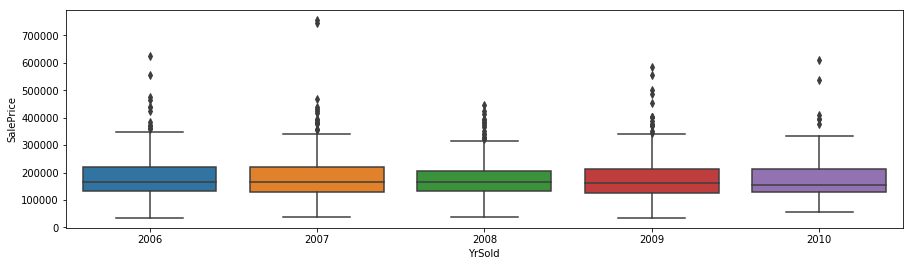

In [18]:
def viz_fields(train):
    for col in train.columns:
        if col == 'SalePrice':
            continue

        tdf = train[[col, 'SalePrice']].dropna()
        if train[col].dtypes == 'object':
            gtype = 'box'
        else:
#             tdf = tdf[tdf[col] > 0]
            if len(train[col].unique()) < 25:
                gtype = 'box'
            else:
                gtype = 'scatter'

        fig, ax = plt.subplots(figsize=(15, 4))
        if gtype == 'box':
            ax = sns.boxplot(x=tdf[col], y=tdf['SalePrice'])

        if gtype == 'scatter':
            ax = sns.regplot(x=tdf[col], y=tdf['SalePrice'])

        plt.show()    
        plt.close()

train, validation = load_data()
viz_fields(train)